A Keras Implementation for GAN.

In [0]:
import keras
from keras import layers
from keras import models
from keras import optimizers

h_dim = 64
height = 32
width = 32
channels = 3

**The Generator**

In [4]:
g_input = layers.Input(shape=(h_dim,))

x = layers.Dense(128*16*16)(g_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x)

x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels,7,activation='tanh',padding='same')(x)

generator = models.Model(g_input,x)
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             2129920   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv

**The Discriminator**

In [5]:
d_input = layers.Input(shape=(height,width,channels))
y = layers.Conv2D(128,3)(d_input)
y = layers.LeakyReLU()(y)
y = layers.Conv2D(128,4,strides=2)(y)
y = layers.LeakyReLU()(y)
y = layers.Conv2D(128,4,strides=2)(y)
y = layers.LeakyReLU()(y)
y = layers.Conv2D(128,4,strides=2)(y)
y = layers.LeakyReLU()(y)
y = layers.Flatten()(y)

y = layers.Dropout(0.4)(y)

y = layers.Dense(1,activation='sigmoid')(y)

discriminator = models.Model(d_input,y)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
___________________________

The disctiminator training optimizer.

In [0]:
d_optim = optimizers.RMSprop(lr=0.08,clipvalue=1.0,decay=1e-8)
discriminator.compile(optimizer=d_optim,loss='binary_crossentropy')

**Adversarial Network**

One thing to remeber, when we train the generator, we want the discriminator keep frozen (not update the weight and only work as eval).

In [0]:
discriminator.trainable = False

gan_input = layers.Input(shape=(h_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input,gan_output)

gan_optim = optimizers.RMSprop(lr=0.08,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=gan_optim,loss='binary_crossentropy')

**Train the DCGAN**

Import the training data first: CIFAR10 data.

In [14]:
from keras.preprocessing import image

(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 4]

x_train = x_train.reshape((x_train.shape[0],)+
                          (height,width,channels)).astype('float32')/255.

x_train.shape

(5000, 32, 32, 3)

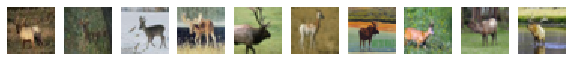

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# The Function used to plot 3-Channel images
def Plot_Img(n,k,n_c,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k,k,n_c))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
Plot_Img(10,32,3,x_train,10,10)

Training Loop

In [0]:
iterations = 10000
batch_size = 20

start = 0
for step in range(iterations):
  
    random_h = np.random.normal(size=(batch_size,h_dim))
    
    generated_imgs = generator.predict(random_h)
    
    stop = start + batch_size
    real_imgs = x_train[start:stop]
    combined_imgs = np.concatenate([generated_imgs,real_imgs])
    labels = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
    labels += 0.5 *np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images,labels)
    
    random_h = np.random.normal(size=(batch_size,h_dim))
    
    fake_labels = np.zeros((batch_size,1))
    
    g_loss = gan.train_on_batch((random_h,fake_labels))
    
    start += batch_size
    if start > len(x_train)-batch_size:
        start = 0
        
    if step % 100 == 0:
        
        print('discriminator loss: ', d_loss)
        print('generator loss: ', gan_loss)
        
        Plot_Img(10,32,3,generated_images,10,10)